# The Best and Worst Pitchers in MLB History

In [26]:
import pandas as pd
pitching = pd.read_csv("../baseballdatabank-2023.1/core/Pitching.csv")

Data courtesy of [Sean Lahman's Baseball](http://www.seanlahman.com/baseball-archive/statistics/)

In [27]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

In [28]:
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,7,NaN,0,146.0,0,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,7,NaN,0,1291.0,0,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,2,NaN,0,14.0,0,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,20,NaN,0,1080.0,1,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,0,NaN,0,57.0,0,21,NaN,NaN,NaN


In [29]:
pitching.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')

## Calculating Pitcher Totals

In [30]:
pitchers = pitching.groupby('playerID').sum()

In [31]:
pitchers.sample(8)

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,,,,,
keenaji02,3841,2,1,2,16,2,0,0,0,106,...,0.0,0,1.0,0,166.0,6,32,0.0,0.0,0.0
ojedaau01,2007,1,0,0,1,0,0,0,0,3,...,0.0,0,0.0,0,3.0,1,0,0.0,0.0,0.0
munozos01,1995,1,2,1,10,3,0,0,0,106,...,0.0,0,1.0,0,164.0,4,28,0.0,1.0,2.0
taylobr01,5934,3,2,2,30,0,0,0,2,147,...,5.0,0,3.0,0,202.0,21,24,6.0,2.0,3.0
howarde01,1905,1,0,0,1,0,0,0,0,18,...,0.0,0,1.0,0,22.0,1,7,0.0,0.0,0.0
byrneto01,29265,17,85,69,281,170,65,12,12,4086,...,10.0,28,85.0,4,6181.0,72,688,0.0,0.0,0.0
leachbr01,2009,1,2,0,38,0,0,0,0,61,...,3.0,5,1.0,0,88.0,6,13,0.0,0.0,2.0
stonebi01,15764,8,54,85,245,169,45,15,5,3709,...,46.0,36,43.0,3,5395.0,28,617,33.0,22.0,12.0


## Adding a WHIP Column

In [32]:
pitchers['WHIP'] = 3 * (pitchers['BB'] + pitchers['IBB'] + pitchers['H']) / pitchers['IPouts']

In [33]:
pitchers['WHIP'].sample(10)

playerID
greasbi01    3.000000
chicktr01    3.400000
smith01      2.333333
ruckena01    1.174572
ballaje01    1.506466
leesa01      1.285714
rescixa01    1.428429
rossty01     1.376197
nunezle01    1.361063
freybe01     1.446552
Name: WHIP, dtype: float64

## Plotting the WHIP Distribution

We'll need to drop the infinite values (from those pitchers who appeared in games but never got an out!).

In [34]:
finite_whips = pitchers[pitchers['WHIP'] != np.inf]

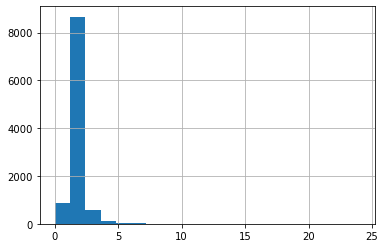

In [35]:
finite_whips['WHIP'].hist(bins=20);

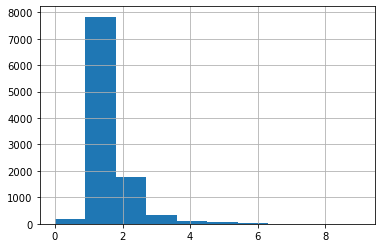

In [36]:
finite_whips[finite_whips['WHIP'] < 10]['WHIP'].hist();

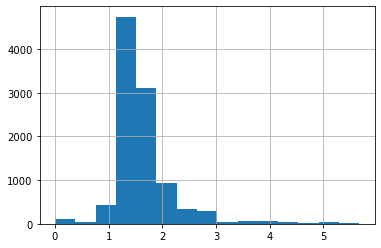

In [37]:
finite_whips[finite_whips['WHIP'] < 6]['WHIP'].hist(bins=15);

This distribution looks much like a **Poisson** Distribution, which is appropriate, since in effect we're talking about predicting a number of events (walks or hits) in a certain amount of time (an inning). The conjugate prior for a Poisson Distribution is a **Gamma** Distribution.

What are our parameters $\alpha$ and $\beta$ for our distribution? We [know](https://stats.stackexchange.com/questions/342639/how-to-find-alpha-and-beta-from-a-gamma-distribution) that $\alpha$ is the ratio of the expectation value of the square of the WHIP to its variance and that $\beta$ is the ratio of the expectation value of the WHIP to its variance. Thus:

In [38]:
alpha = (finite_whips['WHIP']**2).mean() / finite_whips['WHIP'].var()
alpha

5.002007334293972

In [39]:
beta = finite_whips['WHIP'].mean() / finite_whips['WHIP'].var()
beta

2.3923481076306197

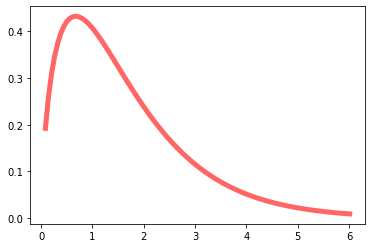

In [40]:
fig, ax = plt.subplots()

a = finite_whips['WHIP'].mean()

x = np.linspace(stats.gamma.ppf(0.01, a),
                stats.gamma.ppf(0.99, a), 100)
ax.plot(x, stats.gamma.pdf(x, a),
       'r-', lw=5, alpha=0.6, label='gamma pdf');

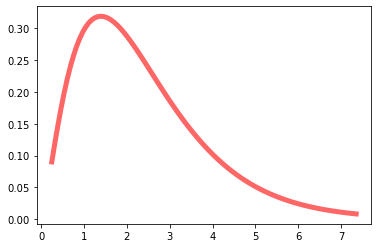

In [41]:
fig, ax = plt.subplots()

x = np.linspace(stats.gamma.ppf(0.01, beta),
                stats.gamma.ppf(0.99, beta), 100)
ax.plot(x, stats.gamma.pdf(x, beta),
       'r-', lw=5, alpha=0.6, label='gamma pdf');

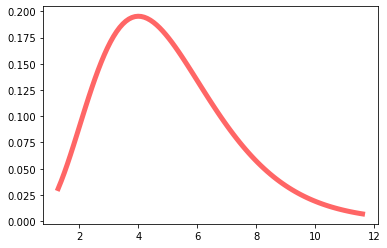

In [42]:
fig, ax = plt.subplots()

x = np.linspace(stats.gamma.ppf(0.01, alpha),
                stats.gamma.ppf(0.99, alpha), 100)
ax.plot(x, stats.gamma.pdf(x, alpha),
       'r-', lw=5, alpha=0.6, label='gamma pdf');

## Typical WHIP

There are a couple different ways we might calculate an "ordinary" WHIP.

In [43]:
# Average over every pitcher's career

finite_whips['WHIP'].mean()

1.6728769083535022

In [44]:
# Total calculation over all innings, hits, and walks

3 * (pitchers['BB'].sum() + pitchers['IBB'].sum() + pitchers['H'].sum()) / pitchers['IPouts'].sum()

1.3732864102190807

The first probably makes more sense, but to simplify, and to give a little bit of credit to the second calculation, let's go with 1.6 as our ordinary WHIP.

## Adding a `MAP_WHIP` column

We can't just look directly at WHIPs, since some pitchers' stats will be misleadingly low or misleadingly high: If someone pitched two innings over their whole career and didn't give up a hit or a walk, that pitcher would have a career WHIP of 0, but that doesn't make him the greatest pitcher of all time.

In [50]:
pitchers.sort_values(['WHIP', 'IPouts'], ascending=[True, False]).head()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,WHIP
playerID,,,,,,,,,,,,,,,,,,,,,
braital01,1915,1,0,0,2,0,0,0,0,9,...,0,0.0,0,0.0,1,0,0.0,0.0,0.0,0.0
gickge01,3875,2,0,0,2,0,0,0,1,9,...,0,1.0,0,10.0,1,0,0.0,0.0,0.0,0.0
tayloed01,1903,1,0,0,1,0,0,0,0,9,...,0,0.0,0,12.0,1,0,0.0,0.0,0.0,0.0
rosscl01,1954,1,0,0,4,0,0,0,1,8,...,0,0.0,0,8.0,3,0,0.0,0.0,0.0,0.0
davisch01,1993,1,0,0,1,0,0,0,0,6,...,0,1.0,0,7.0,1,0,0.0,0.0,0.0,0.0


The man at the top here is [Al Braithwood](https://www.baseball-reference.com/players/b/braital01.shtml). Ever heard of him? No, because, even though he has a career WHIP of 0, he only ever pitched three innings!

So we need some kind of baseline to compare pitchers against. This is why we calculated an average WHIP. This baseline will serve as our Bayesian prior, and, because of the nature of conjugacy, all we need to do is to add this baseline to existing data to calculate a posterior.

In [51]:
pitchers['MAP_WHIP'] = 3 * (pitchers['BB'] + pitchers['IBB'] + pitchers['H'] + 160) / (pitchers['IPouts'] + 300)

In [52]:
pitchers.sort_values('MAP_WHIP', ascending=True).head()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,HBP,BK,BFP,GF,R,SH,SF,GIDP,WHIP,MAP_WHIP
playerID,,,,,,,,,,,,,,,,,,,,,
jossad01,17154,9,160,97,286,260,234,45,5,6981,...,58.0,1,8891.0,22,730,0.0,0.0,0.0,0.967770,0.993820
walshed01,26747,14,195,126,430,315,250,57,35,8893,...,53.0,14,11500.0,104,873,0.0,0.0,0.0,0.999550,1.019145
ueharko01,20128,11,22,26,436,12,0,0,95,1442,...,4.0,0,1862.0,207,153,11.0,9.0,14.0,0.909154,1.028129
janseke01,26208,13,42,28,766,0,0,0,391,2307,...,28.0,11,3040.0,573,225,6.0,15.0,21.0,0.957087,1.031070
kershcl01,30225,15,197,87,401,398,25,15,0,7743,...,39.0,22,10160.0,1,777,90.0,29.0,177.0,1.011623,1.033570


## Trying Different Priors

In [89]:
def whip_prior(wh, ipouts, ascending=False, number=10):
    """
    This function takes in a number of hits plus walks and a number of
    innings to use as prior values for the Bayesian MAP Method. It returns
    the top (worst) hitter according to the MAP average. The ratio
    of hits plus walks to innings should be (near) 8:5. By default it finds
    the *worst* pitchers. To find the best, set the `ascending` parameter
    to True. 
    """
    pitchers['MAP_WHIP'] = 3 * (pitchers['BB'] + pitchers['IBB'] + pitchers['H'] + wh) / (pitchers['IPouts'] + ipouts)
    return pitchers.sort_values('MAP_WHIP', ascending=ascending).head(number)

In [90]:
whip_prior(16, 30)

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,HBP,BK,BFP,GF,R,SH,SF,GIDP,WHIP,MAP_WHIP
playerID,,,,,,,,,,,,,,,,,,,,,
lewis01,1890,1,0,1,1,1,0,0,0,9,...,0.0,0,29.0,0,20,0.0,0.0,0.0,6.666667,2.769231
haasbr01,1915,1,0,1,6,2,1,0,0,43,...,0.0,0,85.0,1,27,0.0,0.0,0.0,3.558140,2.753425
traveal01,1912,1,0,1,1,1,1,0,0,24,...,0.0,0,50.0,0,24,0.0,0.0,0.0,4.125000,2.722222
martipa02,1955,1,0,1,7,1,0,0,0,21,...,1.0,1,49.0,3,12,0.0,0.0,0.0,4.285714,2.705882
bullore01,1936,1,0,2,12,2,0,0,0,50,...,0.0,0,108.0,3,32,0.0,0.0,0.0,3.360000,2.700000
williac01,3886,2,0,0,6,0,0,0,0,27,...,1.0,0,61.0,4,17,0.0,0.0,0.0,3.888889,2.684211
bradyji01,1956,1,0,0,6,0,0,0,0,19,...,0.0,0,43.0,3,21,0.0,0.0,0.0,4.263158,2.632653
vonfrto01,1890,1,0,1,1,1,1,0,0,24,...,0.0,0,55.0,0,16,0.0,0.0,0.0,3.875000,2.611111
dixonst01,3987,2,0,0,6,0,0,0,0,15,...,0.0,0,38.0,0,16,2.0,1.0,1.0,4.600000,2.600000


In [103]:
worsts = {}
for wh in range(10, 1001, 10):
    worsts[wh] = whip_prior(wh, wh*15/8, number=1).iloc[0].name

In [105]:
set(worsts.values())

{'flythst01', 'haasbr01', 'lewis01', 'mcmuljo01', 'stechch01', 'wadswja01'}

In [109]:
results_dict = {}
for j in range(10, 1001, 10):
    if worsts[j] not in results_dict.values():
        results_dict[j] = worsts[j]

In [110]:
results_dict

{10: 'lewis01',
 20: 'haasbr01',
 40: 'flythst01',
 80: 'stechch01',
 300: 'mcmuljo01',
 370: 'wadswja01'}

[William Stecher](https://www.baseball-reference.com/players/s/stechch01.shtml)

In [116]:
pitchers.loc['stechch01']

yearID      1890.000000
stint          1.000000
W              0.000000
L             10.000000
G             10.000000
GS            10.000000
CG             9.000000
SHO            0.000000
SV             0.000000
IPouts       204.000000
H            111.000000
ER            78.000000
HR             1.000000
BB            60.000000
SO            18.000000
BAOpp          0.000000
ERA           10.320000
IBB            0.000000
WP            12.000000
HBP           14.000000
BK             0.000000
BFP          386.000000
GF             0.000000
R            110.000000
SH             0.000000
SF             0.000000
GIDP           0.000000
WHIP           2.514706
MAP_WHIP       1.600622
Name: stechch01, dtype: float64

[Jack Wadsworth](https://www.baseball-reference.com/players/w/wadswja01.shtml)

In [117]:
pitchers.loc['wadswja01']

yearID      7572.000000
stint          4.000000
W              6.000000
L             38.000000
G             47.000000
GS            44.000000
CG            39.000000
SHO            0.000000
SV             0.000000
IPouts      1103.000000
H            524.000000
ER           280.000000
HR            16.000000
BB           199.000000
SO            87.000000
BAOpp          0.000000
ERA           40.050000
IBB            0.000000
WP            32.000000
HBP           10.000000
BK             0.000000
BFP         1808.000000
GF             2.000000
R            393.000000
SH             0.000000
SF             0.000000
GIDP           0.000000
WHIP           1.966455
MAP_WHIP       1.601342
Name: wadswja01, dtype: float64

Let's try some very large number just for the record:

In [114]:
whip_prior(160000, 300000)

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,...,HBP,BK,BFP,GF,R,SH,SF,GIDP,WHIP,MAP_WHIP
playerID,,,,,,,,,,,,,,,,,,,,,
willocl01,13496,7,38,58,219,100,33,4,9,2524,...,18.0,1,3940.0,59,631,0.0,0.0,0.0,1.803090,1.601694
sweetle01,9645,5,33,58,161,95,38,3,4,2222,...,37.0,1,3504.0,36,570,0.0,0.0,0.0,1.822682,1.601637
wadswja01,7572,4,6,38,47,44,39,0,0,1103,...,10.0,0,1808.0,2,393,0.0,0.0,0.0,1.966455,1.601342
walkuji02,13558,8,16,38,116,53,11,1,0,1387,...,5.0,1,2195.0,34,381,0.0,0.0,0.0,1.890411,1.601336
mcmuljo01,7491,4,14,15,37,31,30,0,1,850,...,0.0,0,1513.0,5,405,0.0,0.0,0.0,2.008235,1.601153
kissibi01,7583,5,7,25,53,32,23,0,1,958,...,24.0,0,1568.0,20,342,0.0,0.0,0.0,1.950939,1.601117
lawsoro01,19358,11,47,39,208,83,34,2,11,2555,...,7.0,3,3961.0,78,562,0.0,0.0,0.0,1.731898,1.601114
ellioha01,7722,4,11,24,120,30,4,0,4,967,...,2.0,0,1550.0,42,295,0.0,0.0,0.0,1.945191,1.601109
germale01,13261,8,34,63,130,93,74,0,2,2576,...,53.0,1,4032.0,32,756,0.0,0.0,0.0,1.725932,1.601072


[Claude Willoughby](https://www.baseball-reference.com/players/w/willocl01.shtml)

In [118]:
pitchers.loc['willocl01']

yearID      13496.000000
stint           7.000000
W              38.000000
L              58.000000
G             219.000000
GS            100.000000
CG             33.000000
SHO             4.000000
SV              9.000000
IPouts       2524.000000
H            1111.000000
ER            546.000000
HR             56.000000
BB            406.000000
SO            175.000000
BAOpp           2.220000
ERA            38.640000
IBB             0.000000
WP             22.000000
HBP            18.000000
BK              1.000000
BFP          3940.000000
GF             59.000000
R             631.000000
SH              0.000000
SF              0.000000
GIDP            0.000000
WHIP            1.803090
MAP_WHIP        1.601694
Name: willocl01, dtype: float64

## Distinguishing Between Starters and Relievers